#**Using high-level Keras api (model-subclassing) build a neural network**

In [1]:
import tensorflow as tf
import numpy as np
import math
from tensorflow import keras
from tensorflow.keras import optimizers

In [35]:
#generating 3-d non linear data

n_samples = 200
d = 3
x = tf.random.normal([n_samples, d], -1, 1, tf.float32, seed=1) #casting to float32 

weights_true = tf.cast(tf.constant([[5, 1, 6], [1, 6, 1]]), tf.float32)
bias_true = tf.cast(tf.constant([1, 1]), tf.float32)

y_true = tf.matmul((x ** 2), weights_true, transpose_b=True) + tf.matmul(x, weights_true, transpose_b=True) + bias_true
print(f'x: {x.shape}, weights: {weights_true.shape}, bias: {bias_true.shape}, y: {y_true.shape}')

x: (200, 3), weights: (2, 3), bias: (2,), y: (200, 2)


###Plotting the data

In [36]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_3d(x, y, y_pred=None):
  X_embedded = TSNE(n_components=2).fit_transform(x)

  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(X_embedded[:, 0], X_embedded[:, 1], y, label='underlying function') 
  if y_pred is not None:
    ax.scatter(X_embedded[:, 0], X_embedded[:, 1], y_pred, label='our function')
  plt.legend()

###Plotting y_true

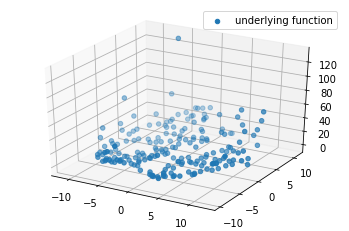

In [48]:
plot_3d(x, y_true)

###Training data using keras linear modules (Model subclassing)

In [38]:
from tensorflow.keras.layers import Layer
class Linear(Layer):

  def __init__(self, units=32):
      super(Linear, self).__init__()
      self.units = units

  def build(self, input_shape):
      self.w = self.add_weight(shape=(input_shape[-1], self.units),
                               initializer='random_normal',
                               trainable=True)
      self.b = self.add_weight(shape=(self.units,),
                               initializer='random_normal',
                               trainable=True)

  def call(self, inputs):
      return tf.matmul(inputs, self.w) + self.b

In [39]:
from tensorflow.keras.layers import Layer

class Dropout(Layer):
  
  def __init__(self, rate):
    super(Dropout, self).__init__()
    self.rate = rate

  def call(self, inputs, training=None):
    if training:
      return tf.nn.dropout(inputs, rate=self.rate)
    return inputs
  
class MLP(Layer):

    def __init__(self):
        super(MLP, self).__init__()
        self.linear_1 = Linear(32)
        self.dropout = Dropout(0.5)
        self.linear_2 = Linear(32)
        self.dropout = Dropout(0.5)
        self.linear_3 = Linear(2)

    def call(self, inputs):
        x = self.linear_1(inputs)
        x = tf.nn.relu(x)
        x = self.dropout(x)
        x = self.linear_2(x)
        x = tf.nn.relu(x)
        x = self.dropout(x)
        return self.linear_3(x)

In [45]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)
loss_fn = tf.keras.losses.MeanSquaredError()
loss_metric = tf.keras.metrics.Mean()

dataset = tf.data.Dataset.from_tensor_slices((x, y_true))
dataset = dataset.shuffle(buffer_size=1).batch(30)

epochs = 700

model = MLP()

for epoch in range(epochs):
    for step, (x_batch, y_batch) in enumerate(dataset):
        with tf.GradientTape() as tape:
            # Forward Pass
            y_pred_batch = model(x_batch)
            # Compute loss
            loss = loss_fn(y_batch, y_pred_batch)
            loss += sum(model.losses)

        grads = tape.gradient(loss, model.trainable_weights) 
        optimizer.apply_gradients(zip(grads, model.trainable_weights)) 

        loss_metric(loss)
    if epoch % 100 == 0:
      print(f'Epoch {epoch}, loss {loss_metric.result()}')

Epoch 0, loss 270.2720031738281
Epoch 100, loss 181.6689910888672
Epoch 200, loss 179.35641479492188
Epoch 300, loss 172.52960205078125
Epoch 400, loss 164.85995483398438
Epoch 500, loss 160.62924194335938
Epoch 600, loss 157.80734252929688


###Plotting the trained data

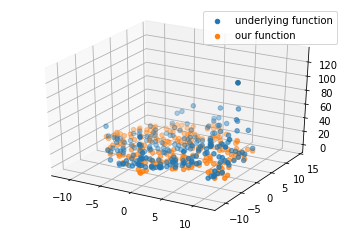

In [46]:
plot_3d(x, y_true, model(x))